#Data Preparation

##Downloading the dataset

In [1]:
import os
import pandas as pd
import zipfile

# ---------------------------
# Step 1: Download and save north.csv locally
# ---------------------------
local_file = "north.csv"
zip_file = "north.csv.zip"

if not os.path.exists(local_file):
    print("north.csv not found locally. Downloading...")
    # Download using the Kaggle CLI command.
    os.system("kaggle datasets download -d PROPPG-PPG/hourly-weather-surface-brazil-southeast-region -f north.csv")

    # After download, the file is saved as a zip archive.
    if os.path.exists(zip_file):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(".")
        print("Downloaded and extracted north.csv")
        os.remove(zip_file)
    else:
        raise FileNotFoundError("Download failed: zip file not found.")
else:
    print("File already exists locally:", local_file)

# ---------------------------
# Step 2: Read the first row to inspect column names
# ---------------------------
header_df = pd.read_csv(local_file, nrows=1, encoding="latin1")
print("Columns in the file:")
print(header_df.columns.tolist())

# ---------------------------
# Step 3: Determine the first station value
# ---------------------------
temp_station = pd.read_csv(local_file, usecols=["station"], nrows=1, encoding="latin1")
first_station = temp_station.iloc[0]["station"]
print("\nFirst station found:", first_station)

# ---------------------------
# Step 4: Load only the reduced columns for the first station using chunked reading
# ---------------------------
usecols = [
    "Data",                                           # Date
    "Hora",                                           # Hour
    "PRECIPITAÃ\x87Ã\x83O TOTAL, HORÃ\x81RIO (mm)",      # Precipitation
    "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",  # Atmospheric Pressure
    "TEMPERATURA DO AR - BULBO SECO, HORARIA (Â°C)",    # Temperature
    "UMIDADE RELATIVA DO AR, HORARIA (%)",              # Relative Humidity
    "VENTO, VELOCIDADE HORARIA (m/s)",                  # Wind Speed
    "station"                                         # Station identifier
]

# Process the file in chunks to avoid memory issues.
chunks = []
chunk_size = 50000

for chunk in pd.read_csv(local_file, usecols=usecols, encoding="latin1", chunksize=chunk_size):
    # Filter for rows that match the first station.
    chunk_filtered = chunk[chunk["station"] == first_station]
    chunks.append(chunk_filtered)

# Concatenate all the filtered chunks into one DataFrame.
df_station = pd.concat(chunks, ignore_index=True)
print("\nData for station", first_station, " (first 5 records):")
print(df_station.head())


north.csv not found locally. Downloading...
Downloaded and extracted north.csv
Columns in the file:
['index', 'Data', 'Hora', 'PRECIPITAÃ\x87Ã\x83O TOTAL, HORÃ\x81RIO (mm)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)', 'PRESSÃ\x83O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)', 'PRESSÃ\x83O ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)', 'RADIACAO GLOBAL (Kj/mÂ²)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (Â°C)', 'TEMPERATURA DO PONTO DE ORVALHO (Â°C)', 'TEMPERATURA MÃ\x81XIMA NA HORA ANT. (AUT) (Â°C)', 'TEMPERATURA MÃ\x8dNIMA NA HORA ANT. (AUT) (Â°C)', 'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (Â°C)', 'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (Â°C)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)', 'UMIDADE RELATIVA DO AR, HORARIA (%)', 'VENTO, DIREÃ\x87Ã\x83O HORARIA (gr) (Â° (gr))', 'VENTO, RAJADA MAXIMA (m/s)', 'VENTO, VELOCIDADE HORARIA (m/s)', 'region', 'state', 'station', 'station_code', 'latitude', 'longitude', 'height']

First sta

In [2]:
df_station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183888 entries, 0 to 183887
Data columns (total 8 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Data                                                   183888 non-null  object 
 1   Hora                                                   183888 non-null  object 
 2   PRECIPITAÃÃO TOTAL, HORÃRIO (mm)                    183888 non-null  float64
 3   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  183888 non-null  float64
 4   TEMPERATURA DO AR - BULBO SECO, HORARIA (Â°C)          183888 non-null  float64
 5   UMIDADE RELATIVA DO AR, HORARIA (%)                    183888 non-null  int64  
 6   VENTO, VELOCIDADE HORARIA (m/s)                        183888 non-null  float64
 7   station                                                183888 non-null  object 
dtypes: float64(4), int64(1), object(3)


In [3]:
print(df_station.describe())

       PRECIPITAÃÃO TOTAL, HORÃRIO (mm)  \
count                        183888.000000   
mean                          -1862.213374   
std                            3892.882371   
min                           -9999.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                              80.800000   

       PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
count                                      183888.000000       
mean                                        -1083.522436       
std                                          4314.334516       
min                                         -9999.000000       
25%                                          1000.700000       
50%                                          1003.600000       
75%                                          1005.500000       
max                                          1037.700000       

       T

## EDA on the Dataset

**Cleans the data:** Replaces `-9999` (used as missing values) with `NaN`.

**Creates a datetime index:** Combines the `"Data"` and `"Hora"` columns.

**Checks for missing values.**

**Visualizes feature distributions:** Using histograms (with KDE) and boxplots.

**Creates time series plots:** For temperature, relative humidity, and wind speed.


Missing values per column:
Date                             0
Hour                             0
Precipitation (mm)           34251
Atmospheric Pressure (mB)    34891
Temperature (°C)             34162
Relative Humidity (%)        34429
Wind Speed (m/s)             40881
station                          0
dtype: int64


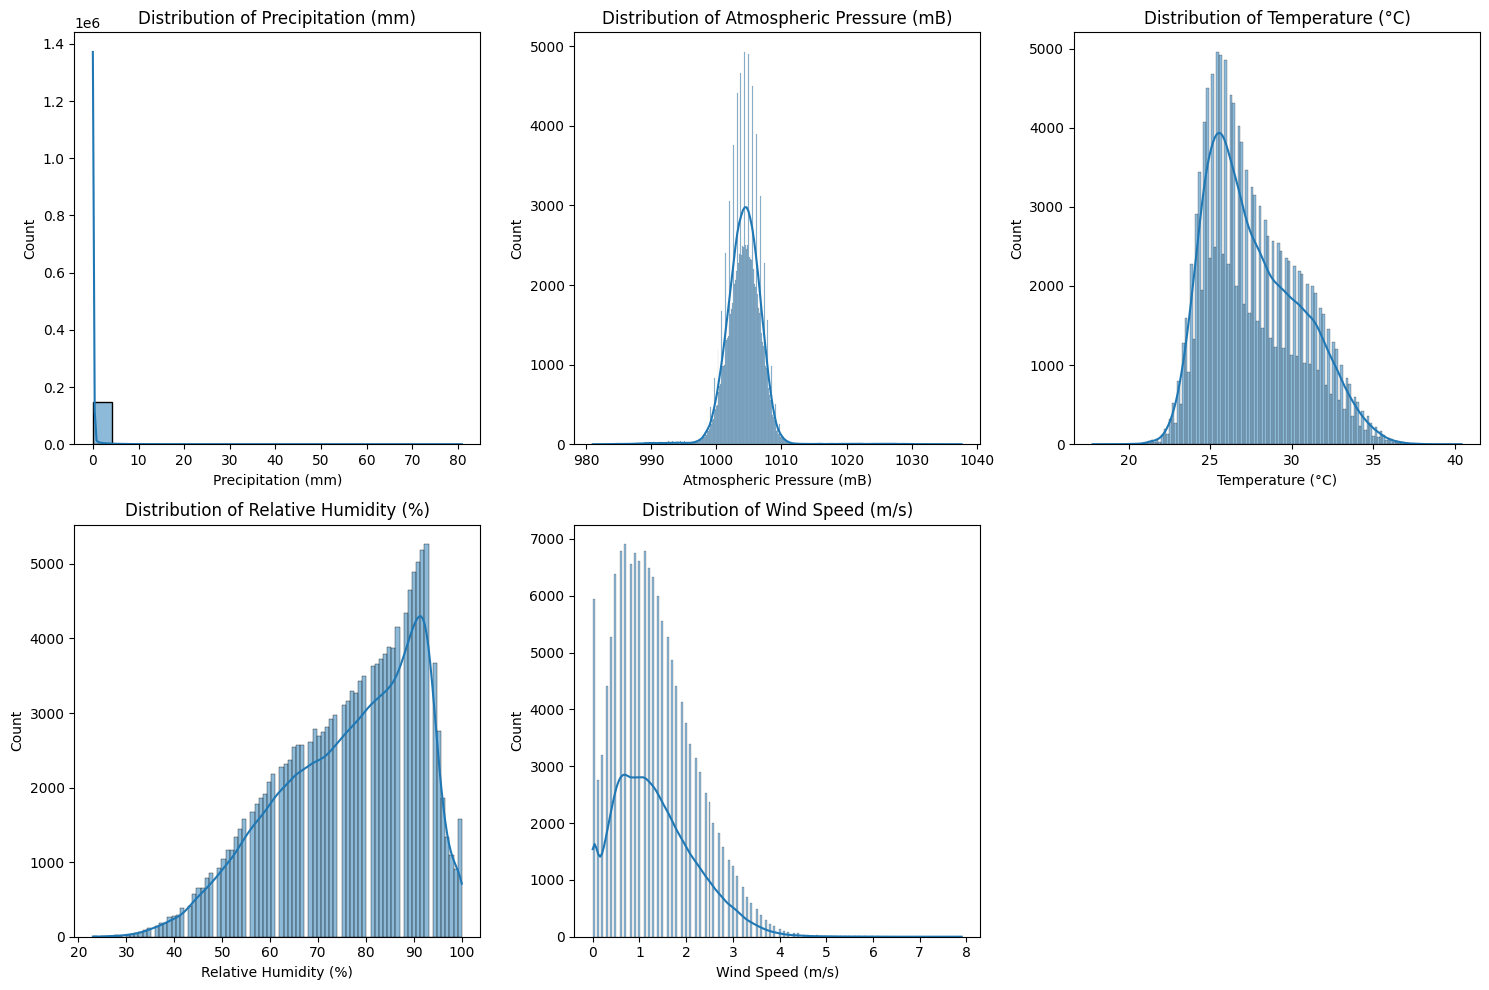

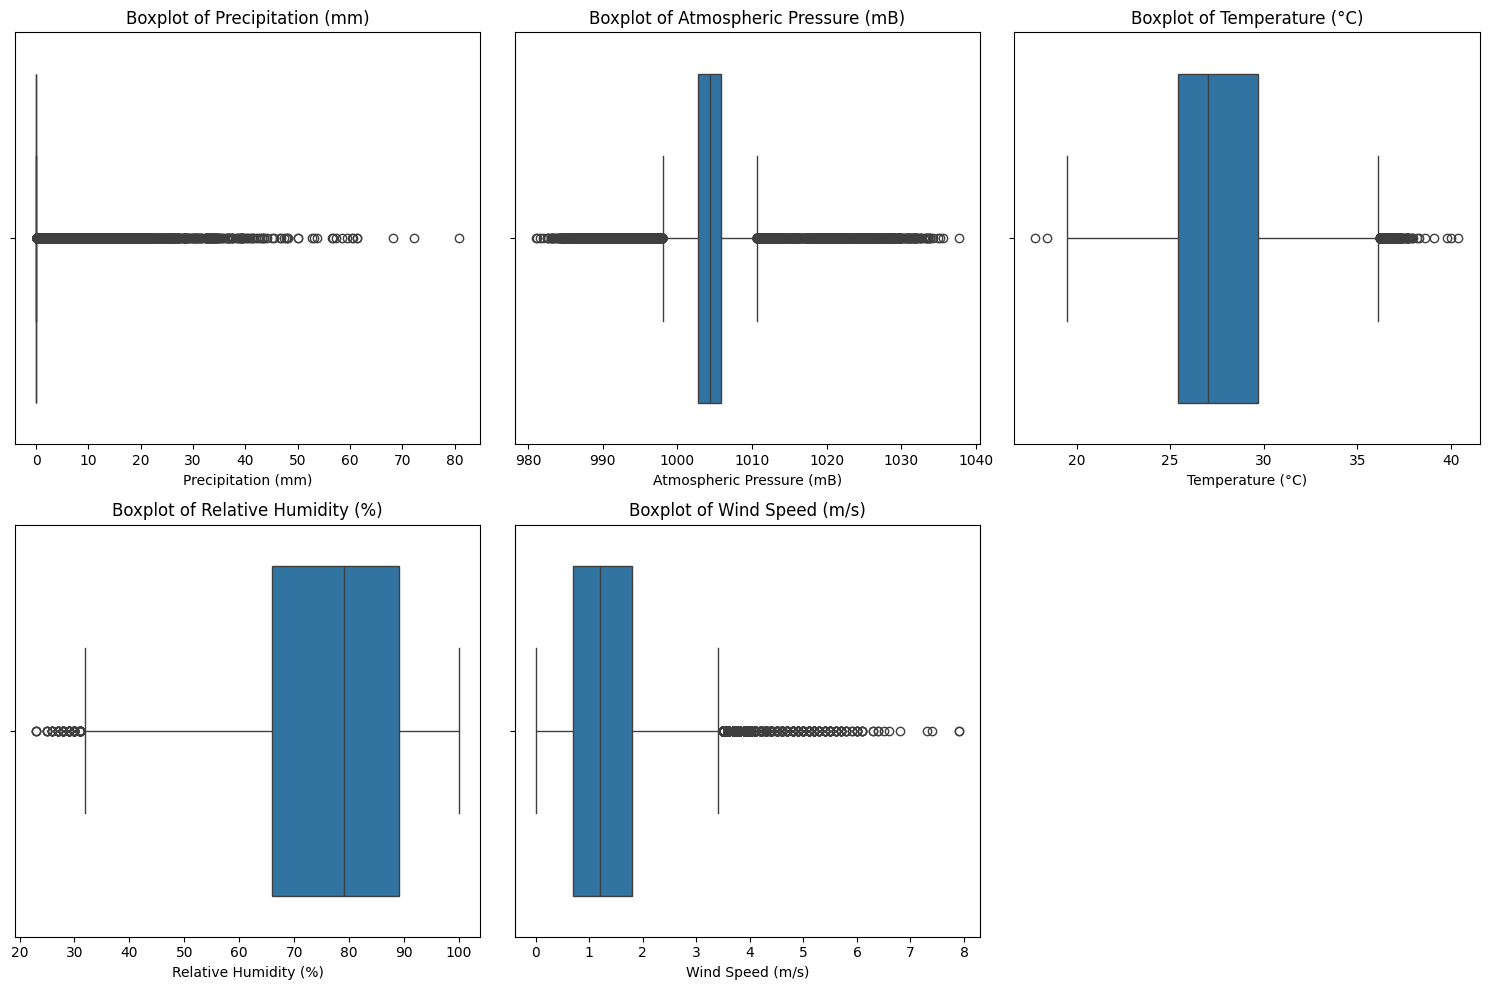

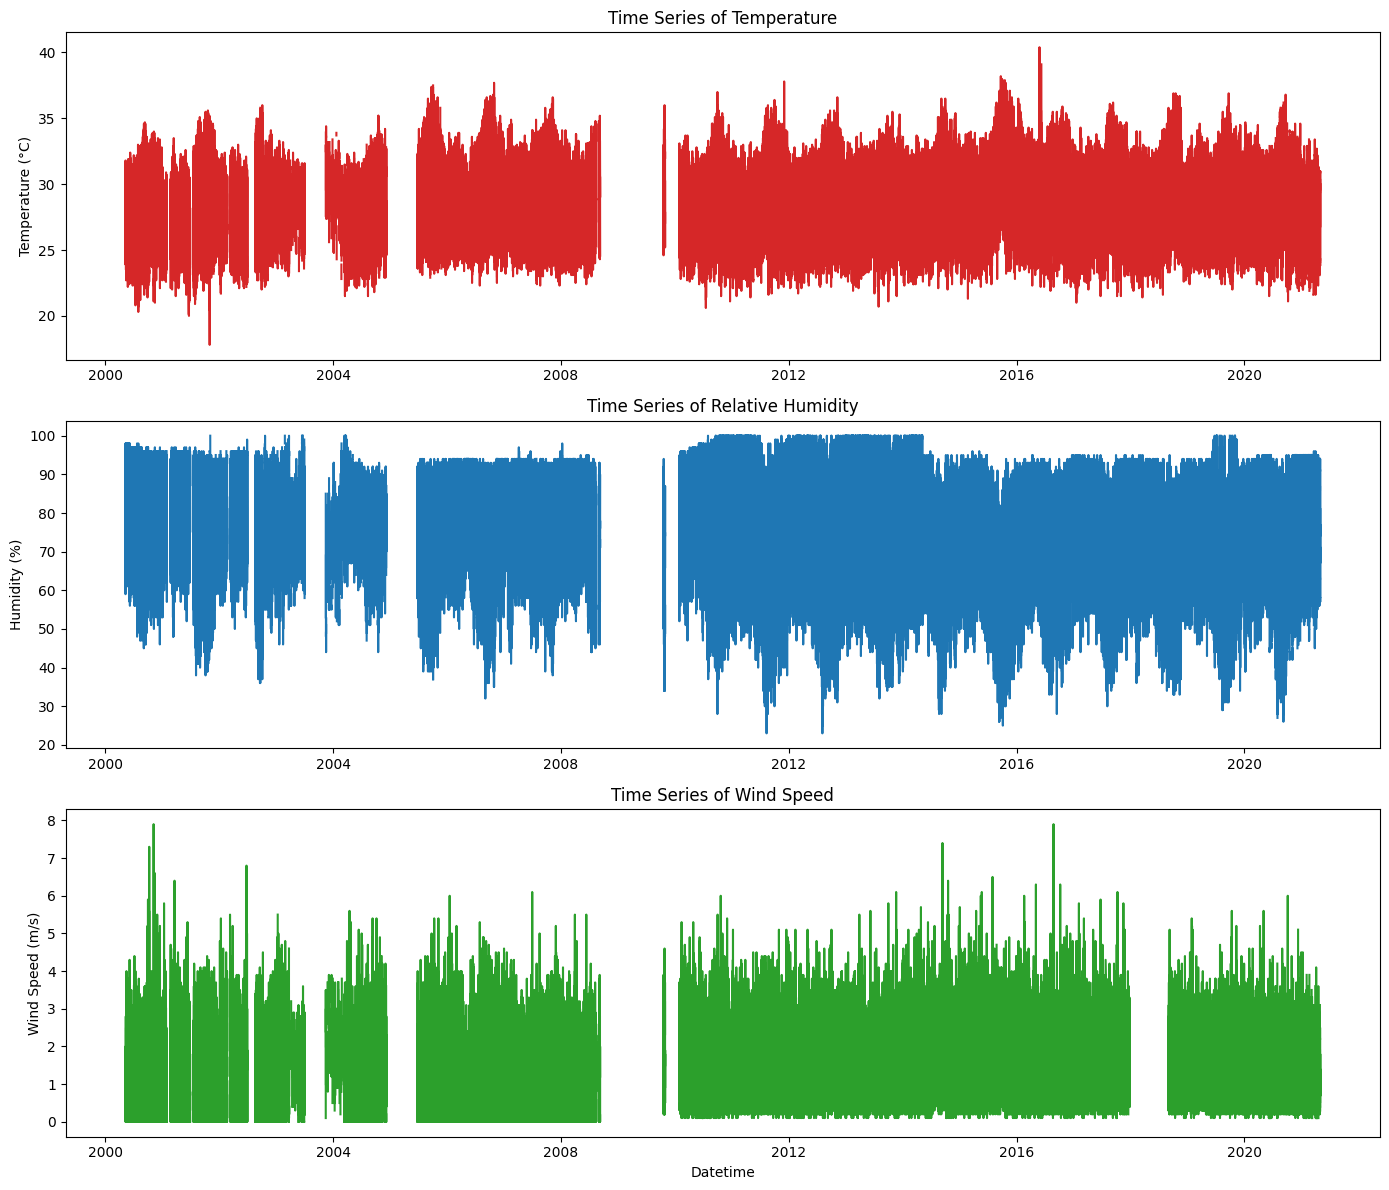

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

# ---------------------------
# Data Cleaning and Datetime Creation
# ---------------------------
# Replace missing values (-9999) with NaN.
cols_to_clean = [
    "PRECIPITAÃÃO TOTAL, HORÃRIO (mm)",
    "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",
    "TEMPERATURA DO AR - BULBO SECO, HORARIA (Â°C)",
    "UMIDADE RELATIVA DO AR, HORARIA (%)",
    "VENTO, VELOCIDADE HORARIA (m/s)"
]
df_station[cols_to_clean] = df_station[cols_to_clean].replace(-9999, np.nan)

# Create a datetime column by combining "Data" and "Hora"
df_station["datetime"] = pd.to_datetime(df_station["Data"] + " " + df_station["Hora"], errors="coerce")
df_station.set_index("datetime", inplace=True)

# ---------------------------
# Rename columns to English names
# ---------------------------
rename_map = {
    "Data": "Date",
    "Hora": "Hour",
    "PRECIPITAÃÃO TOTAL, HORÃRIO (mm)": "Precipitation (mm)",
    "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)": "Atmospheric Pressure (mB)",
    "TEMPERATURA DO AR - BULBO SECO, HORARIA (Â°C)": "Temperature (°C)",
    "UMIDADE RELATIVA DO AR, HORARIA (%)": "Relative Humidity (%)",
    "VENTO, VELOCIDADE HORARIA (m/s)": "Wind Speed (m/s)"
}
df_station.rename(columns=rename_map, inplace=True)

# ---------------------------
# Check for Missing Values
# ---------------------------
print("Missing values per column:")
print(df_station.isna().sum())

# ---------------------------
# Visualize Distributions of Key Features
# ---------------------------
features = ["Precipitation (mm)", "Atmospheric Pressure (mB)", "Temperature (°C)",
            "Relative Humidity (%)", "Wind Speed (m/s)"]

plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_station[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Boxplots for outlier detection
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df_station[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# ---------------------------
# Create Time Series Plots for Temperature, Humidity, and Wind Speed
# ---------------------------
plt.figure(figsize=(14, 12))

# Temperature time series plot
plt.subplot(3, 1, 1)
plt.plot(df_station.index, df_station["Temperature (°C)"], color="tab:red")
plt.title("Time Series of Temperature")
plt.ylabel("Temperature (°C)")

# Relative Humidity time series plot
plt.subplot(3, 1, 2)
plt.plot(df_station.index, df_station["Relative Humidity (%)"], color="tab:blue")
plt.title("Time Series of Relative Humidity")
plt.ylabel("Humidity (%)")

# Wind Speed time series plot
plt.subplot(3, 1, 3)
plt.plot(df_station.index, df_station["Wind Speed (m/s)"], color="tab:green")
plt.title("Time Series of Wind Speed")
plt.ylabel("Wind Speed (m/s)")
plt.xlabel("Datetime")

plt.tight_layout()
plt.show()


## Preprocessing the Dataset

**Handles missing values:** Fills in missing data using forward fill and backward fill.

**Splits the data:** Performs a temporal split into training (70%), validation (15%), and test (15%) sets.

**Normalizes/standardizes features:** Uses the training set to fit scalers and applies the transformation to all splits.

**Creates sequences for time series forecasting:** Uses a sliding window (e.g., past 24 hours as input to forecast the next 6 hours for temperature).


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ---------------------------
# Step 1: Handle Missing Values
# ---------------------------
# For this example, we'll fill missing values by forward filling, then backward filling.
df_filled = df_station.fillna(method='ffill').fillna(method='bfill')

# ---------------------------
# Step 2: Split into Training, Validation, and Test Sets
# ---------------------------
# For forecasting, we focus on the numerical weather features.
# Our selected features:
features = ["Precipitation (mm)", "Atmospheric Pressure (mB)",
            "Temperature (°C)", "Relative Humidity (%)", "Wind Speed (m/s)"]

# We'll use all features as inputs, but our target will be the Temperature.
target_feature = "Temperature (°C)"

# Extract the feature matrix and target series
data = df_filled[features].values   # shape: (n_samples, n_features)
target = df_filled[target_feature].values  # shape: (n_samples,)

# Perform a temporal split:
n_total = len(data)
train_end = int(0.7 * n_total)
val_end = int(0.85 * n_total)

train_data = data[:train_end]
val_data   = data[train_end:val_end]
test_data  = data[val_end:]

train_target = target[:train_end]
val_target   = target[train_end:val_end]
test_target  = target[val_end:]

# ---------------------------
# Step 3: Normalize/Standardize Features
# ---------------------------
# Use StandardScaler and fit only on the training data.
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform input features
train_data_scaled = scaler_x.fit_transform(train_data)
val_data_scaled   = scaler_x.transform(val_data)
test_data_scaled  = scaler_x.transform(test_data)

# For the target (temperature), reshape to 2D for scaling then flatten back.
train_target_scaled = scaler_y.fit_transform(train_target.reshape(-1, 1)).flatten()
val_target_scaled   = scaler_y.transform(val_target.reshape(-1, 1)).flatten()
test_target_scaled  = scaler_y.transform(test_target.reshape(-1, 1)).flatten()

# ---------------------------
# Step 4: Create Sequences for Time Series Forecasting
# ---------------------------
# Define the sequence lengths (past 24 hours for input, next 6 hours for prediction)
seq_length = 24  # input: previous 24 hours
pred_length = 6  # target: next 6 hours

def create_sequences(data_array, target_array, seq_length, pred_length):
    """
    Creates input/output sequences using a sliding window.
    data_array: array of shape (n_samples, n_features)
    target_array: array of shape (n_samples,) for target (temperature)
    Returns: X of shape (n_sequences, seq_length, n_features) and
             y of shape (n_sequences, pred_length)
    """
    X, y = [], []
    total_steps = len(data_array) - seq_length - pred_length + 1
    for i in range(total_steps):
        X.append(data_array[i : i + seq_length])
        y.append(target_array[i + seq_length : i + seq_length + pred_length])
    return np.array(X), np.array(y)

# Create sequences for each split.
X_train, y_train = create_sequences(train_data_scaled, train_target_scaled, seq_length, pred_length)
X_val, y_val     = create_sequences(val_data_scaled, val_target_scaled, seq_length, pred_length)
X_test, y_test   = create_sequences(test_data_scaled, test_target_scaled, seq_length, pred_length)

# Print shapes for verification
print("Train X shape:", X_train.shape)
print("Train y shape:", y_train.shape)
print("Validation X shape:", X_val.shape)
print("Validation y shape:", y_val.shape)
print("Test X shape:", X_test.shape)
print("Test y shape:", y_test.shape)


<ipython-input-5-092c8fb6e3d0>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_station.fillna(method='ffill').fillna(method='bfill')


Train X shape: (128692, 24, 5)
Train y shape: (128692, 6)
Validation X shape: (27554, 24, 5)
Validation y shape: (27554, 6)
Test X shape: (27555, 24, 5)
Test y shape: (27555, 6)


In [6]:
print("Missing values per column:")
print(df_filled.isna().sum())

Missing values per column:
Date                         0
Hour                         0
Precipitation (mm)           0
Atmospheric Pressure (mB)    0
Temperature (°C)             0
Relative Humidity (%)        0
Wind Speed (m/s)             0
station                      0
dtype: int64


#VAE Implementation for Anamoly Detection

## VAE Architecture

**Encoder:** Two hidden layers (dimensions 32 and 16) process the 5-dimensional input.

**Latent space:** A 2-dimensional latent representation is used. This compact latent space is chosen because it’s small enough to force the model to capture the essential normal weather patterns while still allowing for visualization and interpretation.

**Decoder:** Mirrors the encoder with two hidden layers to reconstruct the original 5-dimensional input.

**Reparameterization:** The latent variable is sampled using the standard reparameterization trick.


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=5, latent_dim=2, hidden_dim1=32, hidden_dim2=16):
        super(VAE, self).__init__()
        # Encoder: Input -> Hidden Layers
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # Latent space: Mean and log variance
        self.fc_mu = nn.Linear(hidden_dim2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, latent_dim)

        # Decoder: Latent space -> Hidden Layers -> Reconstruction
        self.fc3 = nn.Linear(latent_dim, hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc5 = nn.Linear(hidden_dim1, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Compute standard deviation and sample epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        reconstruction = self.fc5(h4)
        return reconstruction

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z)
        return reconstruction, mu, logvar

# Instantiate the VAE model
vae_model = VAE(input_dim=5, latent_dim=2, hidden_dim1=32, hidden_dim2=16)
print(vae_model)


VAE(
  (fc1): Linear(in_features=5, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc_mu): Linear(in_features=16, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=16, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=5, bias=True)
)


##Training the VAE

Epoch 001: Train Loss = 0.9277, Val Loss = 0.7738
Epoch 002: Train Loss = 0.8091, Val Loss = 0.7611
Epoch 003: Train Loss = 0.8008, Val Loss = 0.7459
Epoch 004: Train Loss = 0.7973, Val Loss = 0.7542
Epoch 005: Train Loss = 0.7953, Val Loss = 0.7383
Epoch 006: Train Loss = 0.7953, Val Loss = 0.7439
Epoch 007: Train Loss = 0.7946, Val Loss = 0.7452
Epoch 008: Train Loss = 0.7936, Val Loss = 0.7285
Epoch 009: Train Loss = 0.7924, Val Loss = 0.7354
Epoch 010: Train Loss = 0.7909, Val Loss = 0.7337
Epoch 011: Train Loss = 0.7891, Val Loss = 0.7355
Epoch 012: Train Loss = 0.7919, Val Loss = 0.7339
Epoch 013: Train Loss = 0.7891, Val Loss = 0.7374
Epoch 014: Train Loss = 0.7892, Val Loss = 0.7356
Epoch 015: Train Loss = 0.7884, Val Loss = 0.7359
Epoch 016: Train Loss = 0.7881, Val Loss = 0.7280
Epoch 017: Train Loss = 0.7895, Val Loss = 0.7470
Epoch 018: Train Loss = 0.7903, Val Loss = 0.7335
Epoch 019: Train Loss = 0.7880, Val Loss = 0.7360
Epoch 020: Train Loss = 0.7891, Val Loss = 0.7397


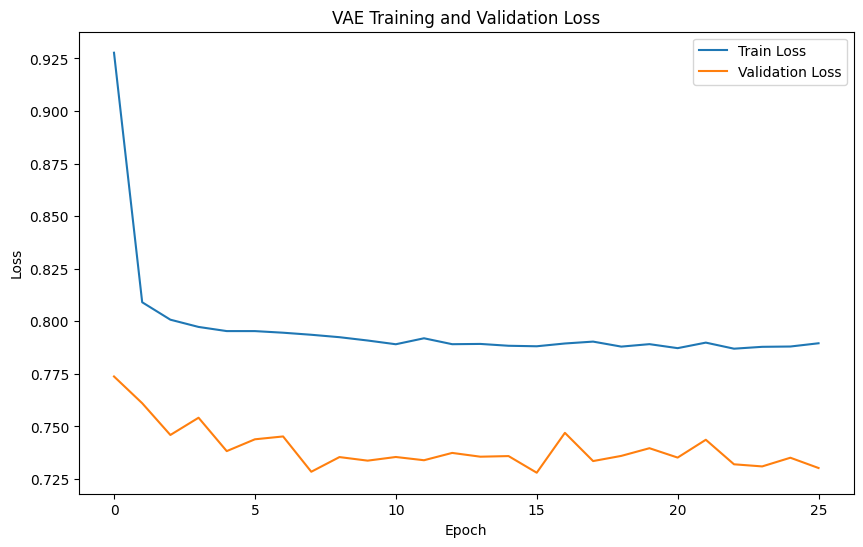

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt



# Convert the numpy arrays (train_data_scaled and val_data_scaled) into torch tensors.
# Here, train_data_scaled and val_data_scaled are from preprocessing.
train_tensor = torch.tensor(train_data_scaled, dtype=torch.float32)
val_tensor = torch.tensor(val_data_scaled, dtype=torch.float32)

# Create datasets and loaders
batch_size = 128
train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the VAE loss function: reconstruction (MSE) + KL divergence
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss: Mean Squared Error (for continuous data)
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    # KL divergence loss
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

# Set up optimizer
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

# Training settings
num_epochs = 100
patience = 10  # epochs to wait for improvement before stopping early
best_val_loss = float('inf')
patience_counter = 0

# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop with early stopping
for epoch in range(num_epochs):
    vae_model.train()
    train_loss_epoch = 0
    for batch in train_loader:
        x = batch[0]
        optimizer.zero_grad()
        recon_x, mu, logvar = vae_model(x)
        loss, recon_loss, kl_loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * x.size(0)
    train_loss_epoch /= len(train_loader.dataset)

    # Validation
    vae_model.eval()
    val_loss_epoch = 0
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0]
            recon_x, mu, logvar = vae_model(x)
            loss, _, _ = vae_loss(recon_x, x, mu, logvar)
            val_loss_epoch += loss.item() * x.size(0)
    val_loss_epoch /= len(val_loader.dataset)

    train_losses.append(train_loss_epoch)
    val_losses.append(val_loss_epoch)

    print(f"Epoch {epoch+1:03d}: Train Loss = {train_loss_epoch:.4f}, Val Loss = {val_loss_epoch:.4f}")

    # Early stopping logic
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        patience_counter = 0
        # Save the best model state
        best_model_state = vae_model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Restore best model state after early stopping
vae_model.load_state_dict(best_model_state)

# ---------------------------
# Visualization of Loss Curves
# ---------------------------
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training and Validation Loss")
plt.legend()
plt.show()


##Evaluation(Anamoly Detection)

Anomaly threshold: 2.380268692970276


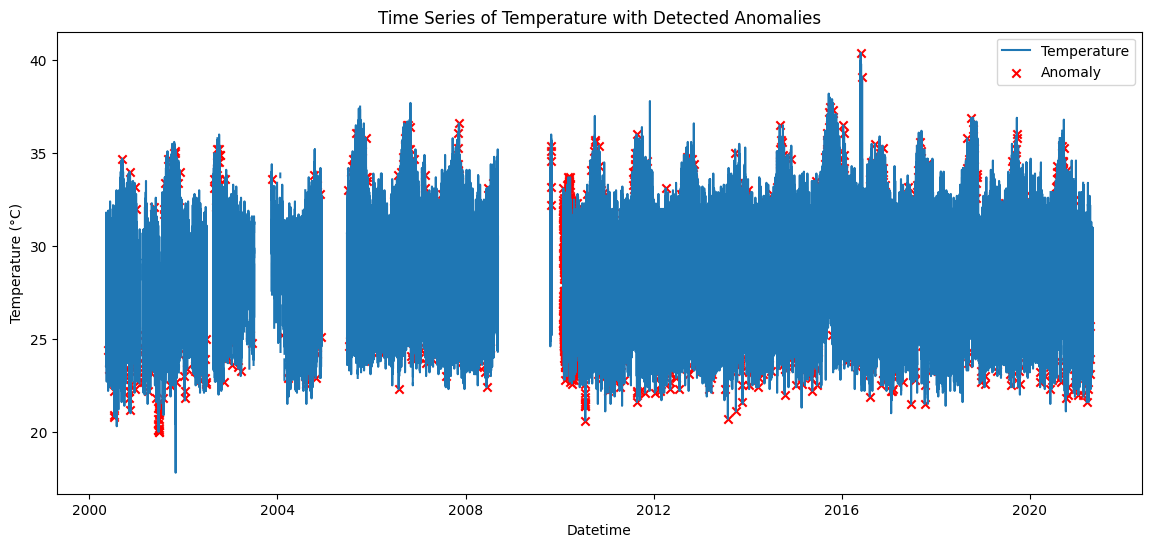

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Compute Reconstruction Error for Each Sample
# ---------------------------
# We use the entire preprocessed dataframe (df_station) that has the English-named columns.
# Extract the features
features = ["Precipitation (mm)", "Atmospheric Pressure (mB)",
            "Temperature (°C)", "Relative Humidity (%)", "Wind Speed (m/s)"]

# Get the data from df_station and transform it using the same scaler (scaler_x) fitted on training data.
data_all = df_station[features].values
data_all_scaled = scaler_x.transform(data_all)

# Convert to a PyTorch tensor.
data_all_tensor = torch.tensor(data_all_scaled, dtype=torch.float32)

# Set the VAE to evaluation mode and compute reconstructions.
vae_model.eval()
with torch.no_grad():
    recon_all, mu, logvar = vae_model(data_all_tensor)
    # Compute the per-sample reconstruction error (MSE for each sample).
    # (We average over the feature dimension.)
    recon_error_all = ((recon_all - data_all_tensor)**2).mean(dim=1).numpy()

# ---------------------------
# Step 2: Define Anomaly Threshold and Mark Anomalies
# ---------------------------
# Attach the reconstruction error to a copy of df_station.
df_anomaly = df_station.copy()
df_anomaly["recon_error"] = recon_error_all

# Define a threshold: here we use the mean + 2 * std of the reconstruction error.
threshold = df_anomaly["recon_error"].mean() + 2 * df_anomaly["recon_error"].std()
print("Anomaly threshold:", threshold)

# Flag samples where the reconstruction error exceeds the threshold.
df_anomaly["anomaly"] = df_anomaly["recon_error"] > threshold

# For day-level anomaly detection: mark a day as anomalous if any hour is anomalous.
df_anomaly["date"] = df_anomaly.index.date
daily_anomaly = df_anomaly.groupby("date")["anomaly"].max()  # True if any hour in that day is anomalous

# ---------------------------
# Step 3: Visualize Anomalies on a Time Series Plot
# ---------------------------
plt.figure(figsize=(14, 6))
plt.plot(df_anomaly.index, df_anomaly["Temperature (°C)"], label="Temperature")
# Overlay anomaly points
plt.scatter(df_anomaly.index[df_anomaly["anomaly"]],
            df_anomaly["Temperature (°C)"][df_anomaly["anomaly"]],
            color="red", label="Anomaly", marker="x")
plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.title("Time Series of Temperature with Detected Anomalies")
plt.legend()
plt.show()


##Latent Space Analysis

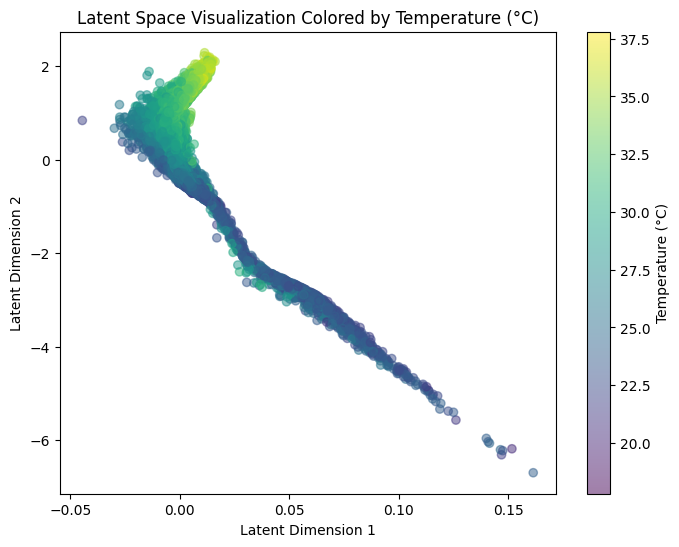

Synthetic Weather Data Samples (first 5 rows):
   Precipitation (mm)  Atmospheric Pressure (mB)  Temperature (°C)  \
0            0.009444                1003.856262         28.795126   
1           -0.002985                1003.309753         30.732077   
2           -0.017743                1002.988586         31.262156   
3           -0.018023                1003.854309         28.857773   
4            0.029638                1003.913513         27.692772   

   Relative Humidity (%)  Wind Speed (m/s)  
0              72.587860          1.523750  
1              62.926292          1.943502  
2              60.014503          2.071861  
3              72.339401          1.535015  
4              77.888519          1.294716  


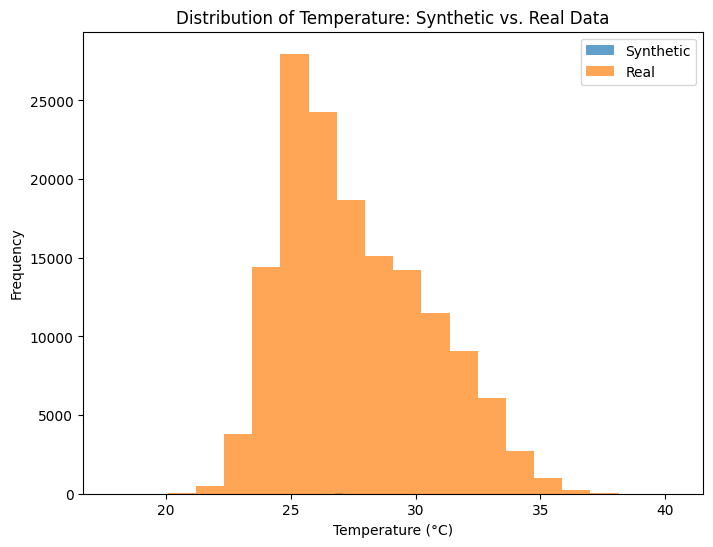

In [10]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------------------------------
# Part 4. Latent Space Analysis
# ---------------------------------------

# 1. Visualize the Latent Space
vae_model.eval()
# Convert training data to tensor (train_data_scaled has shape [n_samples, 5])
train_tensor = torch.tensor(train_data_scaled, dtype=torch.float32)

with torch.no_grad():
    # Encode to get the latent representation; use the mean (mu)
    mu, logvar = vae_model.encode(train_tensor)
    z_train = mu.numpy()

# For visualization, we'll color each point by its temperature.
# Note: our VAE input features are in the order:
# ["Precipitation (mm)", "Atmospheric Pressure (mB)", "Temperature (°C)", "Relative Humidity (%)", "Wind Speed (m/s)"]
# And our target (temperature) is column 2.
# Here, train_target_scaled contains the scaled temperature values; we transform them back to the original scale.
temperature_train_actual = scaler_y.inverse_transform(train_target_scaled.reshape(-1, 1)).flatten()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_train[:, 0], z_train[:, 1], c=temperature_train_actual, cmap="viridis", alpha=0.5)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Visualization Colored by Temperature (°C)")
plt.colorbar(scatter, label="Temperature (°C)")
plt.show()

# 2. Generate New Synthetic Weather Data by Sampling from the Latent Space
num_samples = 100  # number of synthetic samples to generate
# Sample random latent vectors from a standard normal distribution
z_samples = torch.randn(num_samples, 2)

with torch.no_grad():
    # Decode the latent vectors to generate synthetic weather data (in the scaled space)
    synthetic_data_scaled = vae_model.decode(z_samples)
    synthetic_data_scaled = synthetic_data_scaled.numpy()

# Inverse-transform the synthetic data back to the original scale
synthetic_data = scaler_x.inverse_transform(synthetic_data_scaled)

# Create a DataFrame to display synthetic weather samples with the appropriate feature names.
feature_names = ["Precipitation (mm)", "Atmospheric Pressure (mB)",
                 "Temperature (°C)", "Relative Humidity (%)", "Wind Speed (m/s)"]
synthetic_df = pd.DataFrame(synthetic_data, columns=feature_names)

print("Synthetic Weather Data Samples (first 5 rows):")
print(synthetic_df.head())

# Optionally, compare the distribution of one feature (e.g., Temperature) between real and synthetic data.
plt.figure(figsize=(8, 6))
plt.hist(synthetic_df["Temperature (°C)"], bins=20, alpha=0.7, label="Synthetic")
plt.hist(df_station["Temperature (°C)"], bins=20, alpha=0.7, label="Real")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.title("Distribution of Temperature: Synthetic vs. Real Data")
plt.legend()
plt.show()


#GRU Implementation for Time Series Forcasting

##GRU Architecture

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRUForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, pred_length, output_size=1):
        """
        Args:
            input_size: Number of features in the input (e.g., 5 weather metrics)
            hidden_size: Number of units in the GRU hidden layer (e.g., 64)
            num_layers: Number of GRU layers in both encoder and decoder
            pred_length: Number of time steps to forecast (e.g., 6 hours)
            output_size: Dimension of the output (e.g., 1 for single feature prediction such as temperature)
        """
        super(GRUForecast, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.pred_length = pred_length

        # Encoder: Processes the input sequence of shape (batch, N, input_size)
        self.encoder = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

        # Decoder: Generates the forecast sequence.
        # It takes an input of dimension `output_size` (e.g., previous predicted value)
        self.decoder = nn.GRU(output_size, hidden_size, num_layers, batch_first=True)

        # Output layer: Maps hidden state to prediction for each time step.
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_inputs, decoder_targets=None, teacher_forcing_ratio=0.5):
        """
        Args:
            encoder_inputs: Tensor of shape (batch, N, input_size), where N is the past sequence length.
            decoder_targets: Tensor of shape (batch, M, output_size) for teacher forcing (optional).
            teacher_forcing_ratio: Probability to use ground truth at each decoder step.

        Returns:
            outputs: Tensor of shape (batch, M, output_size), where M is the forecast horizon.
        """
        batch_size = encoder_inputs.size(0)

        # Encode the input sequence; we only need the final hidden state.
        _, hidden = self.encoder(encoder_inputs)  # hidden: (num_layers, batch, hidden_size)

        # Initialize decoder input (e.g., a zero vector) for the first time step.
        decoder_input = torch.zeros(batch_size, 1, self.fc.out_features, device=encoder_inputs.device)

        outputs = []
        # Decode one time step at a time for the forecast horizon.
        for t in range(self.pred_length):
            # Decoder step: process the current input and the hidden state.
            out, hidden = self.decoder(decoder_input, hidden)
            # Obtain prediction using the output layer.
            pred = self.fc(out)  # shape: (batch, 1, output_size)
            outputs.append(pred)

            # Teacher Forcing: decide whether to use ground truth or the current prediction.
            if decoder_targets is not None and torch.rand(1).item() < teacher_forcing_ratio:
                # Use ground-truth value as next input.
                decoder_input = decoder_targets[:, t:t+1, :]
            else:
                # Use the prediction as the next input.
                decoder_input = pred

        # Concatenate predictions along the time dimension.
        outputs = torch.cat(outputs, dim=1)  # shape: (batch, pred_length, output_size)
        return outputs

# Configuration:
# - Use past 24 hours (N = 24) of weather data with 5 features.
# - Forecast the next 6 hours (M = 6) of a single target (e.g., temperature).
# - Hidden size is set to 64, and we use 1 GRU layer in both encoder and decoder.
gru_model = GRUForecast(input_size=5, hidden_size=64, num_layers=1, pred_length=6, output_size=1)
print(gru_model)




GRUForecast(
  (encoder): GRU(5, 64, batch_first=True)
  (decoder): GRU(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


##GRU Training

Epoch 01: Train Loss = 0.1033, Val Loss = 0.2346
Epoch 02: Train Loss = 0.1003, Val Loss = 0.2452
Epoch 03: Train Loss = 0.0981, Val Loss = 0.2314
Epoch 04: Train Loss = 0.0959, Val Loss = 0.2263
Epoch 05: Train Loss = 0.0950, Val Loss = 0.2295
Epoch 06: Train Loss = 0.0939, Val Loss = 0.2275
Epoch 07: Train Loss = 0.0946, Val Loss = 0.2229
Epoch 08: Train Loss = 0.0927, Val Loss = 0.2188
Epoch 09: Train Loss = 0.0925, Val Loss = 0.2188
Epoch 10: Train Loss = 0.0923, Val Loss = 0.2187
Epoch 11: Train Loss = 0.0898, Val Loss = 0.2118
Epoch 12: Train Loss = 0.0898, Val Loss = 0.2166
Epoch 13: Train Loss = 0.0896, Val Loss = 0.2119
Epoch 14: Train Loss = 0.0895, Val Loss = 0.2189
Epoch 15: Train Loss = 0.0898, Val Loss = 0.2120
Epoch 16: Train Loss = 0.0881, Val Loss = 0.2099
Epoch 17: Train Loss = 0.0887, Val Loss = 0.2158
Epoch 18: Train Loss = 0.0889, Val Loss = 0.2159
Epoch 19: Train Loss = 0.0886, Val Loss = 0.2132
Epoch 20: Train Loss = 0.0884, Val Loss = 0.2174
Epoch 21: Train Loss

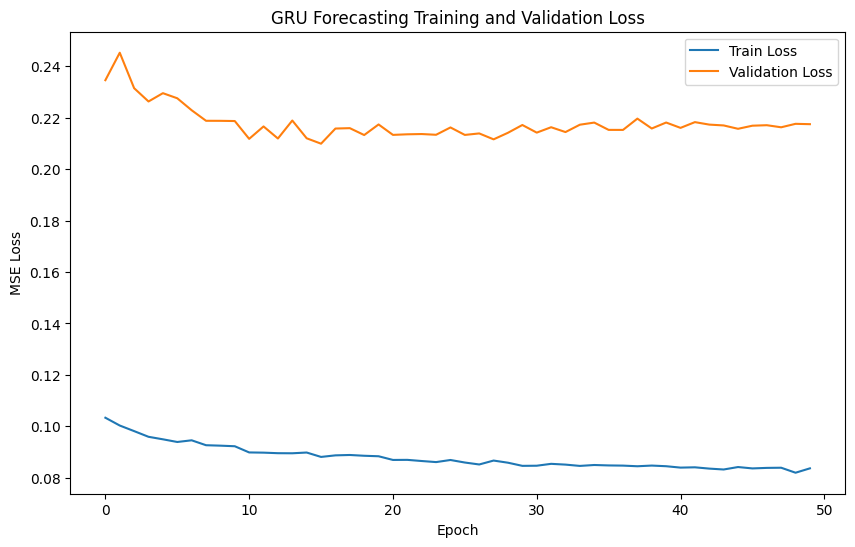

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gru_model.to(device)

# X_train, y_train, X_val, y_val are available from preprocessing.
# Reshape y_train and y_val to have an output dimension (e.g., (n_samples, 6, 1)).
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)  # shape: (n_train, 6, 1)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)    # shape: (n_val, 6, 1)

# Create DataLoaders for batch training.
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Loss function for regression.
criterion = nn.MSELoss()

# Optimizer (Adam) and learning rate scheduler (decays every 10 epochs by a factor of 0.5).
optimizer = optim.Adam(gru_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

num_epochs = 50
teacher_forcing_ratio = 0.5  # During training, 50% probability to use ground truth.
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    gru_model.train()
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # Forward pass with teacher forcing enabled.
        outputs = gru_model(inputs, decoder_targets=targets, teacher_forcing_ratio=teacher_forcing_ratio)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation loop (no teacher forcing).
    gru_model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)       # Move inputs to GPU
            targets = targets.to(device)
            outputs = gru_model(inputs, decoder_targets=targets, teacher_forcing_ratio=0.0)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss /= len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Update the learning rate scheduler.
    scheduler.step()

    print(f"Epoch {epoch+1:02d}: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}")

# Visualize the training and validation loss curves.
plt.figure(figsize=(10,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("GRU Forecasting Training and Validation Loss")
plt.legend()
plt.show()


##Forecasting Evaluation

Overall Test Set Metrics:
MSE: 1.6667
MAE: 0.8662
RMSE: 1.2910

Metrics per Forecast Horizon (Hour):
Hour 1: MSE: 0.7080, MAE: 0.5200, RMSE: 0.8414
Hour 2: MSE: 1.2310, MAE: 0.7283, RMSE: 1.1095
Hour 3: MSE: 1.6232, MAE: 0.8637, RMSE: 1.2741
Hour 4: MSE: 1.9227, MAE: 0.9581, RMSE: 1.3866
Hour 5: MSE: 2.1583, MAE: 1.0318, RMSE: 1.4691
Hour 6: MSE: 2.3571, MAE: 1.0950, RMSE: 1.5353


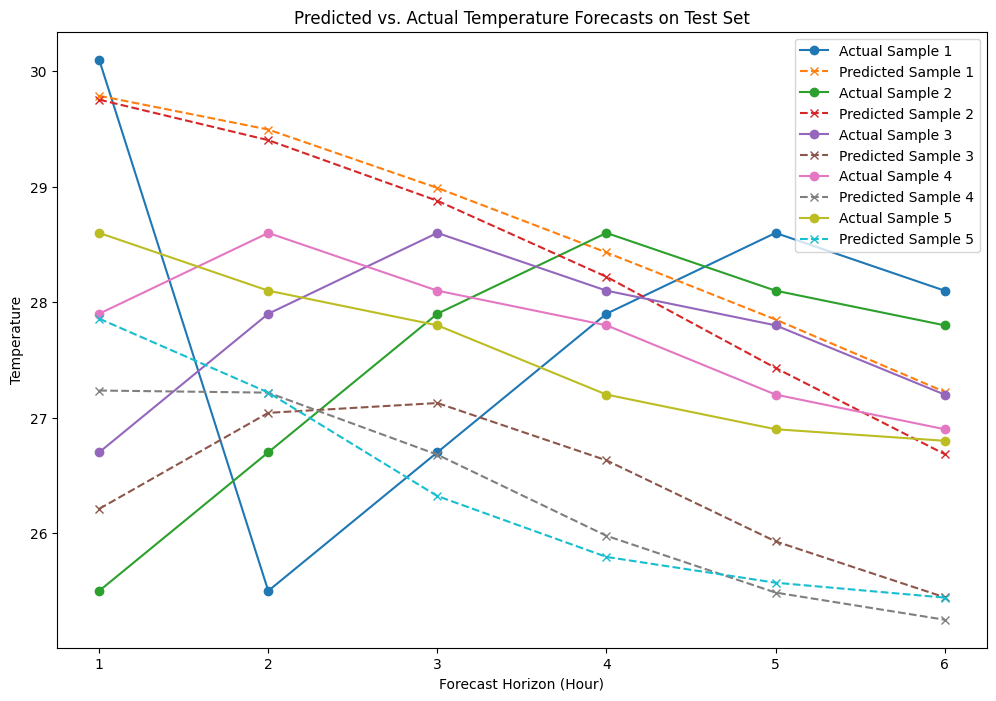

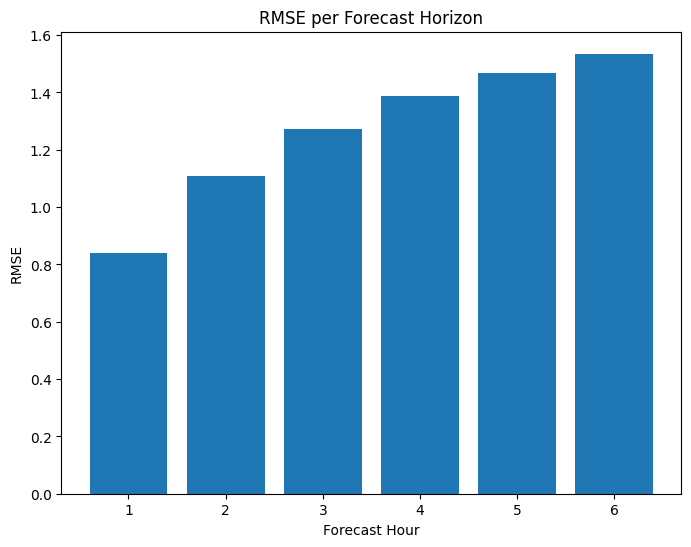

In [19]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# X_test and y_test are available from preprocessing.
# Reshape y_test to have an output dimension.
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)  # shape: (n_test, 6, 1)

# Create a DataLoader for the test set.
batch_size = 128
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the GRU model on the test set (disable teacher forcing during evaluation).
gru_model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        # Ensure data is on the same device as the model.
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass with teacher forcing turned off.
        outputs = gru_model(inputs, decoder_targets=targets, teacher_forcing_ratio=0.0)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

# Concatenate all batches.
predictions = np.concatenate(predictions, axis=0)  # shape: (n_test, 6, 1)
actuals = np.concatenate(actuals, axis=0)          # shape: (n_test, 6, 1)

# Remove the singleton dimension (output_size = 1) -> shape: (n_test, 6)
predictions = predictions.squeeze(-1)
actuals = actuals.squeeze(-1)

# Inverse-transform the predictions and actuals to the original scale.
# Note: scaler_y should have been fitted to the target variable (e.g., temperature).
predictions_inv = scaler_y.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)
actuals_inv = scaler_y.inverse_transform(actuals.reshape(-1, 1)).reshape(actuals.shape)

# ---------------------------
# Compute Overall Metrics
# ---------------------------
mse = mean_squared_error(actuals_inv, predictions_inv)
mae = mean_absolute_error(actuals_inv, predictions_inv)
rmse = np.sqrt(mse)
print("Overall Test Set Metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# ---------------------------
# Compute Metrics Per Forecast Horizon
# ---------------------------
num_steps = predictions_inv.shape[1]  # forecast horizon length (e.g., 6)
metrics_per_step = {}
for t in range(num_steps):
    mse_t = mean_squared_error(actuals_inv[:, t], predictions_inv[:, t])
    mae_t = mean_absolute_error(actuals_inv[:, t], predictions_inv[:, t])
    rmse_t = np.sqrt(mse_t)
    metrics_per_step[t+1] = {"MSE": mse_t, "MAE": mae_t, "RMSE": rmse_t}

print("\nMetrics per Forecast Horizon (Hour):")
for hour, metrics in metrics_per_step.items():
    print(f"Hour {hour}: MSE: {metrics['MSE']:.4f}, MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}")

# ---------------------------
# Visualize Predictions vs. Actual Values
# ---------------------------
# Plot predictions vs. actual values for a few samples.
num_samples_to_plot = 5  # adjust as needed
plt.figure(figsize=(12, 8))
for i in range(num_samples_to_plot):
    plt.plot(range(1, num_steps+1), actuals_inv[i, :], marker='o', label=f"Actual Sample {i+1}")
    plt.plot(range(1, num_steps+1), predictions_inv[i, :], marker='x', linestyle='--', label=f"Predicted Sample {i+1}")
plt.xlabel("Forecast Horizon (Hour)")
plt.ylabel("Temperature")
plt.title("Predicted vs. Actual Temperature Forecasts on Test Set")
plt.legend()
plt.show()

# ---------------------------
# Visualize RMSE per Forecast Horizon
# ---------------------------
rmse_values = [metrics_per_step[t+1]["RMSE"] for t in range(num_steps)]
plt.figure(figsize=(8, 6))
plt.bar(range(1, num_steps+1), rmse_values)
plt.xlabel("Forecast Hour")
plt.ylabel("RMSE")
plt.title("RMSE per Forecast Horizon")
plt.show()


##Ablation Study

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# GRU-based forecasting model
class GRUForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, pred_length, output_size=1):
        """
        Args:
            input_size: Number of input features (e.g., 5 weather metrics)
            hidden_size: Number of hidden units (e.g., 64)
            num_layers: Number of recurrent layers
            pred_length: Forecast horizon (e.g., 6 hours)
            output_size: Output dimension (e.g., 1 for temperature)
        """
        super(GRUForecast, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.pred_length = pred_length

        # Encoder processes the past sequence.
        self.encoder = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # Decoder generates forecasts.
        self.decoder = nn.GRU(output_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_inputs, decoder_targets=None, teacher_forcing_ratio=0.5):
        batch_size = encoder_inputs.size(0)
        _, hidden = self.encoder(encoder_inputs)
        # Initialize decoder input with zeros.
        decoder_input = torch.zeros(batch_size, 1, self.fc.out_features, device=encoder_inputs.device)
        outputs = []
        for t in range(self.pred_length):
            out, hidden = self.decoder(decoder_input, hidden)
            pred = self.fc(out)  # (batch, 1, output_size)
            outputs.append(pred)
            # Use teacher forcing if available.
            if decoder_targets is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = decoder_targets[:, t:t+1, :]
            else:
                decoder_input = pred
        outputs = torch.cat(outputs, dim=1)  # (batch, pred_length, output_size)
        return outputs

# LSTM-based forecasting model
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, pred_length, output_size=1):
        super(LSTMForecast, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.pred_length = pred_length
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(output_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_inputs, decoder_targets=None, teacher_forcing_ratio=0.5):
        batch_size = encoder_inputs.size(0)
        _, (hidden, cell) = self.encoder(encoder_inputs)
        decoder_input = torch.zeros(batch_size, 1, self.fc.out_features, device=encoder_inputs.device)
        outputs = []
        for t in range(self.pred_length):
            out, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.fc(out)
            outputs.append(pred)
            if decoder_targets is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = decoder_targets[:, t:t+1, :]
            else:
                decoder_input = pred
        outputs = torch.cat(outputs, dim=1)
        return outputs

# RNN-based forecasting model (vanilla RNN)
class RNNForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, pred_length, output_size=1):
        super(RNNForecast, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.pred_length = pred_length
        self.encoder = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.RNN(output_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_inputs, decoder_targets=None, teacher_forcing_ratio=0.5):
        batch_size = encoder_inputs.size(0)
        _, hidden = self.encoder(encoder_inputs)
        decoder_input = torch.zeros(batch_size, 1, self.fc.out_features, device=encoder_inputs.device)
        outputs = []
        for t in range(self.pred_length):
            out, hidden = self.decoder(decoder_input, hidden)
            pred = self.fc(out)
            outputs.append(pred)
            if decoder_targets is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = decoder_targets[:, t:t+1, :]
            else:
                decoder_input = pred
        outputs = torch.cat(outputs, dim=1)
        return outputs

# Example instantiation (using hyperparameters common to all):
if __name__ == "__main__":
    input_size = 5       # e.g., 5 weather metrics
    hidden_size = 64     # can be adjusted based on data complexity
    num_layers = 1       # single layer for simplicity
    pred_length = 6      # forecast next 6 hours
    output_size = 1      # predicting a single value (e.g., temperature)

    gru_model = GRUForecast(input_size, hidden_size, num_layers, pred_length, output_size)
    lstm_model = LSTMForecast(input_size, hidden_size, num_layers, pred_length, output_size)
    rnn_model = RNNForecast(input_size, hidden_size, num_layers, pred_length, output_size)

    print("GRU Model:")
    print(gru_model)
    print("\nLSTM Model:")
    print(lstm_model)
    print("\nRNN Model:")
    print(rnn_model)


GRU Model:
GRUForecast(
  (encoder): GRU(5, 64, batch_first=True)
  (decoder): GRU(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

LSTM Model:
LSTMForecast(
  (encoder): LSTM(5, 64, batch_first=True)
  (decoder): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RNN Model:
RNNForecast(
  (encoder): RNN(5, 64, batch_first=True)
  (decoder): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


Training GRUForecast Model...
Epoch 01: Train Loss = 0.1553, Val Loss = 0.2367
Epoch 02: Train Loss = 0.1030, Val Loss = 0.2310
Epoch 03: Train Loss = 0.0994, Val Loss = 0.2357
Epoch 04: Train Loss = 0.0975, Val Loss = 0.2319
Epoch 05: Train Loss = 0.0960, Val Loss = 0.2234
Epoch 06: Train Loss = 0.0953, Val Loss = 0.2298
Epoch 07: Train Loss = 0.0949, Val Loss = 0.2325
Epoch 08: Train Loss = 0.0940, Val Loss = 0.2212
Epoch 09: Train Loss = 0.0942, Val Loss = 0.2189
Epoch 10: Train Loss = 0.0937, Val Loss = 0.2187
Epoch 11: Train Loss = 0.0909, Val Loss = 0.2136
Epoch 12: Train Loss = 0.0912, Val Loss = 0.2126
Epoch 13: Train Loss = 0.0902, Val Loss = 0.2150
Epoch 14: Train Loss = 0.0897, Val Loss = 0.2112
Epoch 15: Train Loss = 0.0890, Val Loss = 0.2135
Epoch 16: Train Loss = 0.0900, Val Loss = 0.2227
Epoch 17: Train Loss = 0.0896, Val Loss = 0.2129
Epoch 18: Train Loss = 0.0899, Val Loss = 0.2143
Epoch 19: Train Loss = 0.0904, Val Loss = 0.2197
Epoch 20: Train Loss = 0.0887, Val Loss

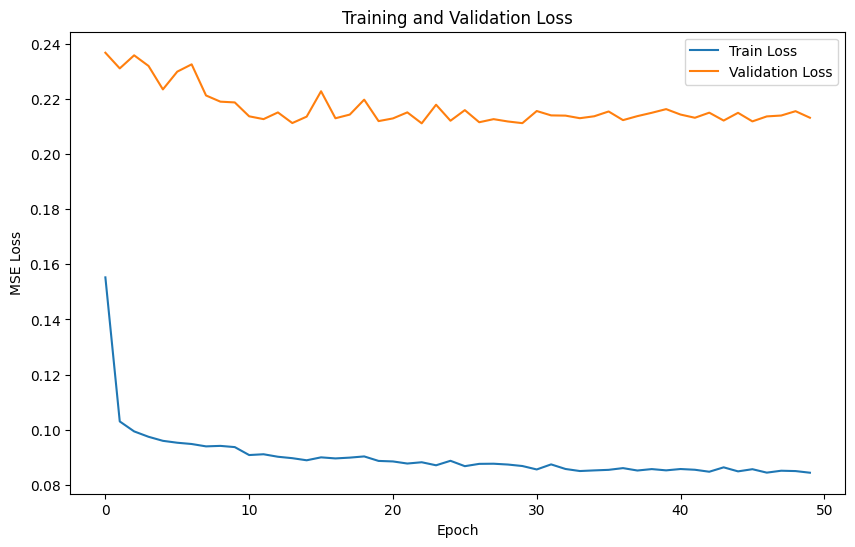

Training LSTMForecast Model...
Epoch 01: Train Loss = 0.1558, Val Loss = 0.2949
Epoch 02: Train Loss = 0.1029, Val Loss = 0.2316
Epoch 03: Train Loss = 0.0999, Val Loss = 0.2368
Epoch 04: Train Loss = 0.0978, Val Loss = 0.2270
Epoch 05: Train Loss = 0.0968, Val Loss = 0.2238
Epoch 06: Train Loss = 0.0961, Val Loss = 0.2350
Epoch 07: Train Loss = 0.0941, Val Loss = 0.2218
Epoch 08: Train Loss = 0.0946, Val Loss = 0.2295
Epoch 09: Train Loss = 0.0940, Val Loss = 0.2283
Epoch 10: Train Loss = 0.0924, Val Loss = 0.2260
Epoch 11: Train Loss = 0.0918, Val Loss = 0.2146
Epoch 12: Train Loss = 0.0916, Val Loss = 0.2194
Epoch 13: Train Loss = 0.0899, Val Loss = 0.2213
Epoch 14: Train Loss = 0.0895, Val Loss = 0.2169
Epoch 15: Train Loss = 0.0899, Val Loss = 0.2206
Epoch 16: Train Loss = 0.0899, Val Loss = 0.2176
Epoch 17: Train Loss = 0.0881, Val Loss = 0.2183
Epoch 18: Train Loss = 0.0885, Val Loss = 0.2162
Epoch 19: Train Loss = 0.0893, Val Loss = 0.2206
Epoch 20: Train Loss = 0.0885, Val Los

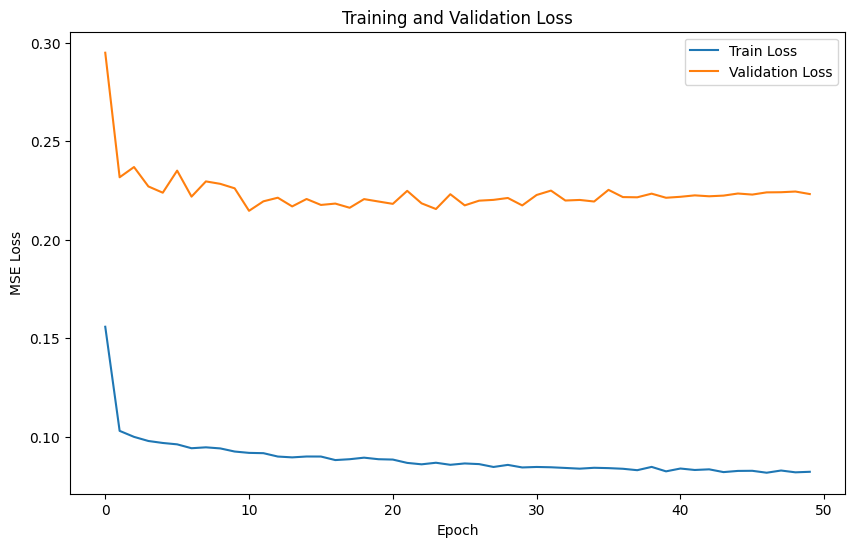

Training RNNForecast Model...
Epoch 01: Train Loss = 0.1462, Val Loss = 0.2474
Epoch 02: Train Loss = 0.1095, Val Loss = 0.2578
Epoch 03: Train Loss = 0.1066, Val Loss = 0.2474
Epoch 04: Train Loss = 0.1021, Val Loss = 0.2373
Epoch 05: Train Loss = 0.1022, Val Loss = 0.2331
Epoch 06: Train Loss = 0.1011, Val Loss = 0.2494
Epoch 07: Train Loss = 0.1012, Val Loss = 0.2568
Epoch 08: Train Loss = 0.1006, Val Loss = 0.2372
Epoch 09: Train Loss = 0.0994, Val Loss = 0.2353
Epoch 10: Train Loss = 0.0987, Val Loss = 0.2272
Epoch 11: Train Loss = 0.0961, Val Loss = 0.2295
Epoch 12: Train Loss = 0.0962, Val Loss = 0.2279
Epoch 13: Train Loss = 0.0963, Val Loss = 0.2266
Epoch 14: Train Loss = 0.0954, Val Loss = 0.2249
Epoch 15: Train Loss = 0.0963, Val Loss = 0.2306
Epoch 16: Train Loss = 0.0963, Val Loss = 0.2210
Epoch 17: Train Loss = 0.0959, Val Loss = 0.2206
Epoch 18: Train Loss = 0.0946, Val Loss = 0.2237
Epoch 19: Train Loss = 0.0952, Val Loss = 0.2270
Epoch 20: Train Loss = 0.0948, Val Loss

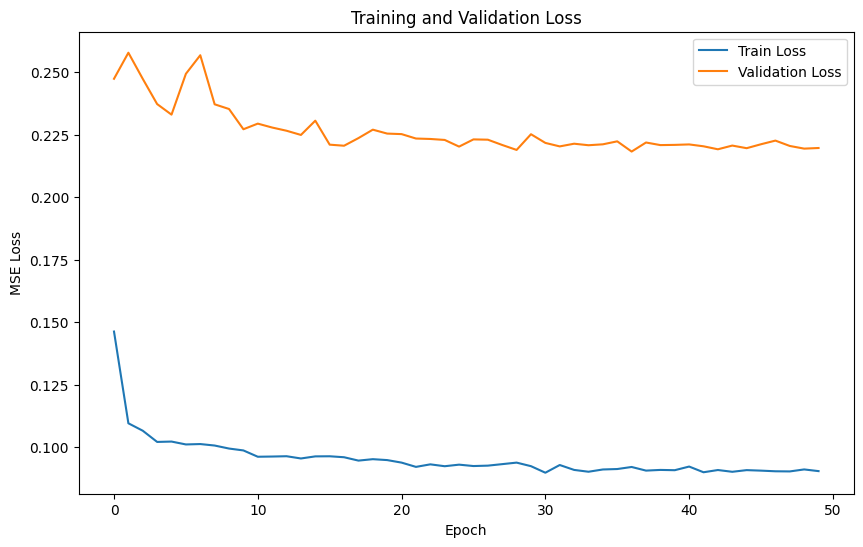

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# X_*: shape (n_samples, seq_length, num_features)
# y_*: shape (n_samples, pred_length)  --> We reshape them to (n_samples, pred_length, 1)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# Create DataLoaders
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training function
def train_model(model, num_epochs=50, teacher_forcing_ratio=0.5, learning_rate=1e-3):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, decoder_targets=targets, teacher_forcing_ratio=teacher_forcing_ratio)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation loop (without teacher forcing)
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs, decoder_targets=targets, teacher_forcing_ratio=0.0)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item() * inputs.size(0)
        epoch_val_loss /= len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        scheduler.step()
        print(f"Epoch {epoch+1:02d}: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}")

    # Plot training and validation losses
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    return model



# Define common hyperparameters.
input_size = X_train.shape[2]  # number of features (e.g., 5)
hidden_size = 64
num_layers = 1
pred_length = y_train.shape[1]  # forecast horizon (e.g., 6)
output_size = 1

# Experiment 1: GRUForecast
gru_model = GRUForecast(input_size, hidden_size, num_layers, pred_length, output_size)
print("Training GRUForecast Model...")
gru_model = train_model(gru_model)

# Experiment 2: LSTMForecast
lstm_model = LSTMForecast(input_size, hidden_size, num_layers, pred_length, output_size)
print("Training LSTMForecast Model...")
lstm_model = train_model(lstm_model)

# Experiment 3: RNNForecast
rnn_model = RNNForecast(input_size, hidden_size, num_layers, pred_length, output_size)
print("Training RNNForecast Model...")
rnn_model = train_model(rnn_model)


=== Model Architecture Comparison ===
GRU Model: MSE = 0.1951, MAE = 0.2948, RMSE = 0.4417
LSTM Model: MSE = 0.2036, MAE = 0.2998, RMSE = 0.4512
RNN Model: MSE = 0.1970, MAE = 0.2970, RMSE = 0.4438

=== Sequence Length Analysis (GRU Model) ===
Sequence Length 12: MSE = 0.4198, MAE = 0.4694, RMSE = 0.6479
Sequence Length 24: MSE = 0.1951, MAE = 0.2948, RMSE = 0.4417
Sequence Length 48: MSE = 0.2536, MAE = 0.3251, RMSE = 0.5036

=== Feature Impact Analysis (GRU Model) ===
Feature Set Full: MSE = 0.9069, MAE = 0.7934, RMSE = 0.9523
Feature Set Temp+Humidity: MSE = 0.9245, MAE = 0.8091, RMSE = 0.9615
Feature Set Temperature: MSE = 0.9199, MAE = 0.7932, RMSE = 0.9591


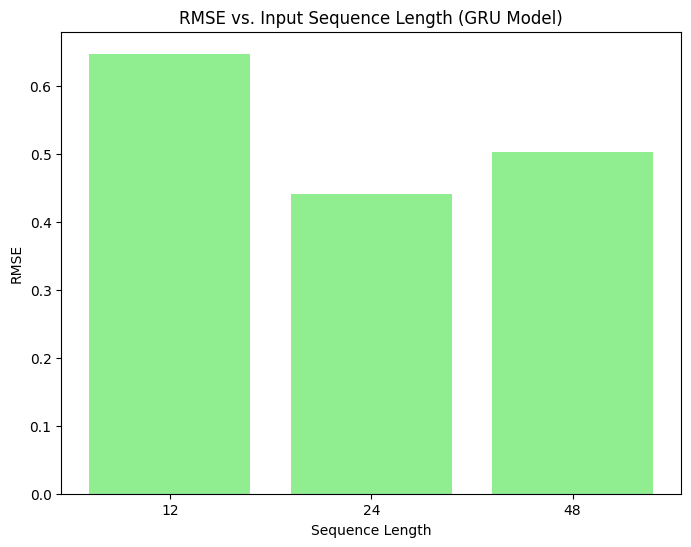

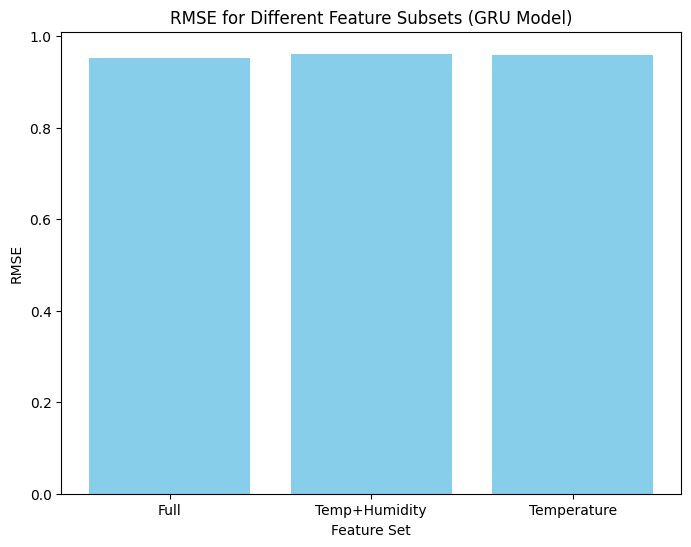

In [24]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Helper Function for Evaluation ----------
def evaluate_model(model, data_loader):
    """
    Evaluates the given forecasting model on the provided data loader.
    Returns overall MSE, MAE, and RMSE computed on the model's predictions.
    """
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs, decoder_targets=targets, teacher_forcing_ratio=0.0)
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())
    predictions = np.concatenate(predictions, axis=0).squeeze(-1)  # shape: (n_samples, pred_length)
    actuals = np.concatenate(actuals, axis=0).squeeze(-1)
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)
    return mse, mae, rmse

# ---------- 1. Model Architecture Comparison ----------
print("=== Model Architecture Comparison ===")
# Create a DataLoader for the original test set (assumes X_test shape: (n_samples, 24, 5))
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Assume gru_model, lstm_model, rnn_model are already trained and defined.
models = {
    "GRU": gru_model,
    "LSTM": lstm_model,
    "RNN": rnn_model
}

for name, model in models.items():
    mse, mae, rmse = evaluate_model(model, test_loader)
    print(f"{name} Model: MSE = {mse:.4f}, MAE = {mae:.4f}, RMSE = {rmse:.4f}")

# ---------- 2. Sequence Length Analysis (using GRU) ----------
# Assume raw test data arrays: test_data_scaled and test_target_scaled are available.
# Also assume create_sequences is defined as:
# def create_sequences(data_array, target_array, seq_length, pred_length):
#     # returns X_seq, y_seq

print("\n=== Sequence Length Analysis (GRU Model) ===")
sequence_lengths = [12, 24, 48]
results_seq = {}

for seq_length in sequence_lengths:
    X_test_seq, y_test_seq = create_sequences(test_data_scaled, test_target_scaled, seq_length, pred_length)
    X_test_seq_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test_seq_tensor = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(-1)
    test_dataset_seq = TensorDataset(X_test_seq_tensor, y_test_seq_tensor)
    test_loader_seq = DataLoader(test_dataset_seq, batch_size=128, shuffle=False)

    mse, mae, rmse = evaluate_model(gru_model, test_loader_seq)
    results_seq[seq_length] = (mse, mae, rmse)
    print(f"Sequence Length {seq_length}: MSE = {mse:.4f}, MAE = {mae:.4f}, RMSE = {rmse:.4f}")

# ---------- 3. Feature Impact Analysis (using GRU with re-instantiated models) ----------
print("\n=== Feature Impact Analysis (GRU Model) ===")
# The original X_test has shape (n_samples, 24, 5), with feature order:
# [0] Precipitation, [1] Atmospheric Pressure, [2] Temperature, [3] Relative Humidity, [4] Wind Speed
feature_sets = {
    "Full": [0, 1, 2, 3, 4],
    "Temp+Humidity": [2, 3],
    "Temperature": [2]
}
results_feat = {}

# Assume that hidden_size, num_layers, pred_length, output_size are defined (as before)
for feat_name, indices in feature_sets.items():
    # Select the corresponding feature subset along axis=2.
    X_test_subset = X_test[:, :, indices]
    new_input_size = len(indices)

    # Re-instantiate a new GRUForecast model with input_size = new_input_size.
    model_feature = GRUForecast(new_input_size, hidden_size, num_layers, pred_length, output_size).to(device)
    # Note: For a fair ablation study, this model should be trained on data with these features.

    X_test_subset_tensor = torch.tensor(X_test_subset, dtype=torch.float32)
    test_dataset_subset = TensorDataset(X_test_subset_tensor, y_test_tensor)
    test_loader_subset = DataLoader(test_dataset_subset, batch_size=128, shuffle=False)

    mse, mae, rmse = evaluate_model(model_feature, test_loader_subset)
    results_feat[feat_name] = (mse, mae, rmse)
    print(f"Feature Set {feat_name}: MSE = {mse:.4f}, MAE = {mae:.4f}, RMSE = {rmse:.4f}")

# ---------- Optional: Visualizing Results ----------
# Bar chart for sequence length analysis.
plt.figure(figsize=(8, 6))
seq_labels = [str(s) for s in sequence_lengths]
rmse_values = [results_seq[s][2] for s in sequence_lengths]
plt.bar(seq_labels, rmse_values, color='lightgreen')
plt.xlabel("Sequence Length")
plt.ylabel("RMSE")
plt.title("RMSE vs. Input Sequence Length (GRU Model)")
plt.show()

# Bar chart for feature impact analysis.
plt.figure(figsize=(8, 6))
feat_labels = list(results_feat.keys())
rmse_feat = [results_feat[feat][2] for feat in feat_labels]
plt.bar(feat_labels, rmse_feat, color='skyblue')
plt.xlabel("Feature Set")
plt.ylabel("RMSE")
plt.title("RMSE for Different Feature Subsets (GRU Model)")
plt.show()


#Model Integration and Analysis

Anomaly threshold for sequence average error: 0.8505346179008484
Number of normal sequences: 26250, Number of anomalous sequences: 1305

GRU Forecasting Performance on Normal Sequences:
MSE: 1.6494, MAE: 0.8546, RMSE: 1.2843

GRU Forecasting Performance on Anomalous Sequences:
MSE: 1.3637, MAE: 0.8362, RMSE: 1.1678


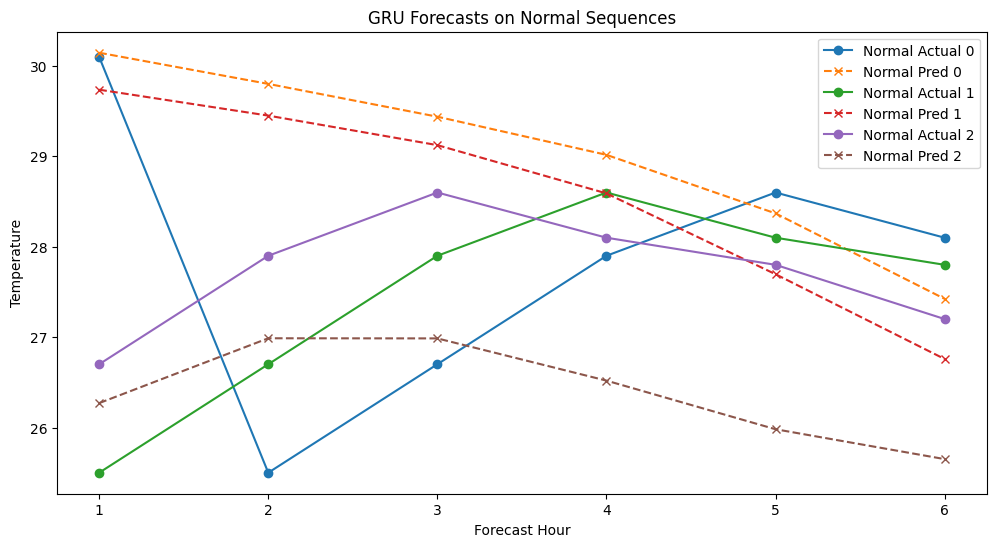

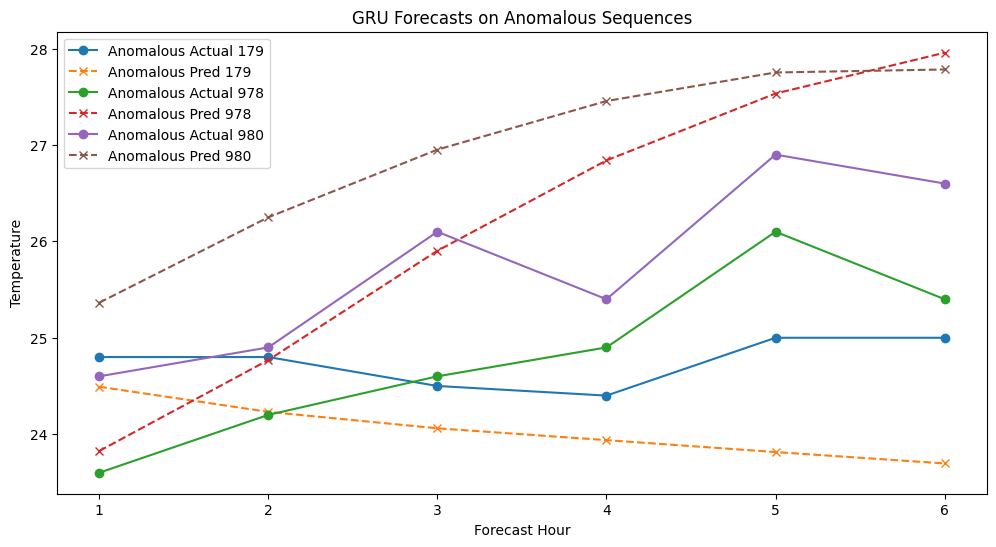

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Integration: VAE for Anomaly Detection on GRU Inputs ---

# Assume:
# - X_test is a NumPy array of shape (n_test, seq_length, 5) for GRU forecasting.
# - scaler_x was used for the VAE training (i.e. inputs are standardized).
# - scaler_y is used for the target variable (e.g., temperature).
# - vae_model (trained) and gru_model (trained) are available.
# - device is set to "cuda" if available.

# Ensure the VAE model is on the same device.
vae_model.to(device)

n_test, seq_length, num_features = X_test.shape

# Reshape X_test to process each time step individually with the VAE.
X_test_reshaped = X_test.reshape(-1, num_features)  # shape: (n_test * seq_length, 5)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32).to(device)

vae_model.eval()
with torch.no_grad():
    # Compute reconstructions for each time step.
    recon, mu, logvar = vae_model(X_test_tensor)
    # Compute per-sample MSE reconstruction error (averaged over features)
    recon_error = ((recon - X_test_tensor)**2).mean(dim=1).cpu().numpy()

# Reshape the reconstruction errors back to (n_test, seq_length) and average per sequence.
recon_error_seq = recon_error.reshape(n_test, seq_length)
avg_recon_error_seq = recon_error_seq.mean(axis=1)

# Define an anomaly threshold (e.g., mean + 2*std of sequence-average error).
threshold = np.mean(avg_recon_error_seq) + 2 * np.std(avg_recon_error_seq)
print("Anomaly threshold for sequence average error:", threshold)

# Flag sequences as anomalous if their average error exceeds the threshold.
anomaly_flags = avg_recon_error_seq > threshold  # Boolean array of shape (n_test,)
num_anomalous = np.sum(anomaly_flags)
num_normal = n_test - num_anomalous
print(f"Number of normal sequences: {num_normal}, Number of anomalous sequences: {num_anomalous}")

# --- GRU Forecasting Evaluation on Normal vs. Anomalous Sequences ---

# Assume X_test, y_test, and test_loader are available.
# y_test is a NumPy array of shape (n_test, pred_length) and we'll reshape it to (n_test, pred_length, 1).
# Here we re-run inference with the GRU model on the test set.
gru_model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = gru_model(inputs, decoder_targets=targets, teacher_forcing_ratio=0.0)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

# Concatenate predictions and actuals.
predictions = np.concatenate(predictions, axis=0).squeeze(-1)  # shape: (n_test, pred_length)
actuals = np.concatenate(actuals, axis=0).squeeze(-1)          # shape: (n_test, pred_length)

# Inverse transform to the original scale using scaler_y.
predictions_inv = scaler_y.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)
actuals_inv = scaler_y.inverse_transform(actuals.reshape(-1, 1)).reshape(actuals.shape)

# Separate indices for normal and anomalous sequences.
normal_indices = np.where(~anomaly_flags)[0]
anomalous_indices = np.where(anomaly_flags)[0]

def compute_metrics(pred, act):
    mse = mean_squared_error(act, pred)
    mae = mean_absolute_error(act, pred)
    rmse = np.sqrt(mse)
    return mse, mae, rmse

mse_normal, mae_normal, rmse_normal = compute_metrics(predictions_inv[normal_indices], actuals_inv[normal_indices])
mse_anom, mae_anom, rmse_anom = compute_metrics(predictions_inv[anomalous_indices], actuals_inv[anomalous_indices])

print("\nGRU Forecasting Performance on Normal Sequences:")
print(f"MSE: {mse_normal:.4f}, MAE: {mae_normal:.4f}, RMSE: {rmse_normal:.4f}")
print("\nGRU Forecasting Performance on Anomalous Sequences:")
print(f"MSE: {mse_anom:.4f}, MAE: {mae_anom:.4f}, RMSE: {rmse_anom:.4f}")

# --- Visualization of Forecasts for Normal vs. Anomalous Sequences ---

num_samples_to_plot = 3  # adjust as needed

plt.figure(figsize=(12, 6))
for idx in normal_indices[:num_samples_to_plot]:
    plt.plot(range(1, predictions_inv.shape[1]+1), actuals_inv[idx], marker='o', label=f"Normal Actual {idx}")
    plt.plot(range(1, predictions_inv.shape[1]+1), predictions_inv[idx], marker='x', linestyle='--', label=f"Normal Pred {idx}")
plt.xlabel("Forecast Hour")
plt.ylabel("Temperature")
plt.title("GRU Forecasts on Normal Sequences")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for idx in anomalous_indices[:num_samples_to_plot]:
    plt.plot(range(1, predictions_inv.shape[1]+1), actuals_inv[idx], marker='o', label=f"Anomalous Actual {idx}")
    plt.plot(range(1, predictions_inv.shape[1]+1), predictions_inv[idx], marker='x', linestyle='--', label=f"Anomalous Pred {idx}")
plt.xlabel("Forecast Hour")
plt.ylabel("Temperature")
plt.title("GRU Forecasts on Anomalous Sequences")
plt.legend()
plt.show()